In [6]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [7]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

In [8]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [9]:
from tqdm import tqdm
import cv2 as cv
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

hand_signs = os.listdir("data/train")

images = []
labels = []

for sign in hand_signs:
    path = "data/train/" + sign

    for image in tqdm(os.listdir(path), desc=f"Loading images for {sign}"):
        img = cv.imread(path + "/" + image)
        img = cv.resize(img, (320, 190))
        if img is not None:
            images.append(img)
            labels.append(sign)

print("\nConverting training images to np array with float32 values scaled")
X = np.array(images).astype("float32")

print("\nEncoding Y properly to a understandable format")
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

print("\nOne Hot Encoding training labels")
y = y.reshape(-1, 1)
one_hot_encoder = OneHotEncoder()
Y = one_hot_encoder.fit_transform(y)

Loading images for boar: 100%|██████████| 172/172 [00:03<00:00, 56.27it/s]



Converting training images to np array with float32 values scaled

Encoding Y properly to a understandable format

One Hot Encoding training labels


In [10]:
hand_signs = os.listdir("data/test")

images_test = []
labels_test = []

for sign in hand_signs:
    path = "data/test/" + sign

    for image in tqdm(os.listdir(path), desc=f"Loading images for {sign}"):
        img = cv.imread(path + "/" + image)
        img = cv.resize(img, (320, 190))
        if img is not None:
            images_test.append(img)
            labels_test.append(sign)

print("\nConverting training images to np array with float32 values scaled")
X_test = np.array(images_test).astype("float32")

print("\nEncoding Y properly to a understandable format")
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(labels_test)

print("\nOne Hot Encoding training labels")
y_test = y_test.reshape(-1, 1)
one_hot_encoder = OneHotEncoder()
Y_test = one_hot_encoder.fit_transform(y_test)

Loading images for boar: 100%|██████████| 10/10 [00:00<00:00, 127.91it/s]



Converting training images to np array with float32 values scaled

Encoding Y properly to a understandable format

One Hot Encoding training labels


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

def create_vgg_model(input_shape=X[0].shape, num_classes=13):
    with tf.device("/gpu:0"):
        vgg_model = VGG16(
            include_top=False,
            input_shape=input_shape,
            pooling="avg",
            weights="imagenet"
        )

        for layer in vgg_model.layers[:-5]:
            layer.trainable = False

        x = Dense(4096, activation="relu")(vgg_model.output)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        x = Dense(1024, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)
        x = Dense(512, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)
        output = Dense(num_classes, activation="softmax", name="Prediction")(x)

        model = Model(inputs=vgg_model.input, outputs=output, name="Sharingan")

    return model

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.sparse import issparse

def train_model(model, X, Y, X_test, Y_test):
    with tf.device("/gpu:0"):
        if issparse(X):
            X = X.toarray()
        if issparse(Y):
            Y = Y.toarray()
        if issparse(X_test):
            X_test = X_test.toarray()
        if issparse(Y_test):
            Y_test = Y_test.toarray()

        X = np.asarray(X)
        Y = np.asarray(Y)
        X_test = np.asarray(X_test)
        Y_test = np.asarray(Y_test)

        train_datagen = ImageDataGenerator(
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            brightness_range=[0.8, 1.2],
            preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
        )

        val_datagen = ImageDataGenerator(
            preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
        )

        model.compile(
            loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            metrics=['accuracy']
        )

        batch_size = 48
        val_size = 32

        callbacks = [
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_accuracy',
                factor=0.5,
                patience=3,
                min_delta=0.001,
                min_lr=1e-9
            ),
            tf.keras.callbacks.ModelCheckpoint(
                './models_other/best_VGG_Classifier.keras',
                save_best_only=True,
                monitor='val_accuracy'
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                min_delta=0.001,
                mode='min'
            )
        ]

        train_gen = train_datagen.flow(X, Y, batch_size=batch_size)
        val_gen = val_datagen.flow(X_test, Y_test, batch_size=val_size)

        history = model.fit(
            train_gen,
            validation_data=val_gen,
            steps_per_epoch=len(X) // batch_size,
            validation_steps=None,
            epochs=100,
            callbacks=callbacks,
        )

        return history

In [13]:
model = create_vgg_model(num_classes=len(hand_signs))
model.summary()
history = train_model(model, X, Y, X_test, Y_test)

I0000 00:00:1731261522.015209    3473 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1731261522.017843    3473 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2229 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "Sharingan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 190, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 190, 320, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 190, 320, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 95, 160, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 95, 160, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 95, 160, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 47, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 47, 80, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 47, 80, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 47, 80, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 23, 40, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 23, 40, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 23, 40, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 23, 40, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 20, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 10, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     2,101,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     4,195,32

 Total params: 21,565,261 (82.26 MB)

 Trainable params: 13,918,733 (53.10 MB)

 Non-trainable params: 7,646,528 (29.17 MB)

/home/beebadoobee/code/naruto-hand-sign/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1731261527.222188  192796 service.cc:148] XLA service 0x79800c016c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731261527.222212  192796 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-11-10 23:28:47.299920: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731261527.736192  192796 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-10 23:28:47.970386: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-11

18/44 ━━━━━━━━━━━━━━━━━━━━ 14s 553ms/step - accuracy: 0.2008 - loss: 2.8761

2024-11-10 23:29:33.176822: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1082', 176 bytes spill stores, 176 bytes spill loads

2024-11-10 23:29:33.968982: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1082_0', 1128 bytes spill stores, 1376 bytes spill loads

2024-11-10 23:29:35.896673: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3006', 112 bytes spill stores, 112 bytes spill loads

2024-11-10 23:29:36.280595: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3342', 68 bytes spill stores, 68 bytes spill loads

2024-11-10 23:29:37.392320: I external/local_xla/x

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3406 - loss: 2.3240

2024-11-10 23:30:11.348608: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_251_0', 100 bytes spill stores, 100 bytes spill loads

2024-11-10 23:30:12.066705: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_251', 168 bytes spill stores, 168 bytes spill loads

2024-11-10 23:30:14.111259: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:359] gpu_async_0 cuMemAllocAsync failed to allocate 2282291200 bytes: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
 Reported by CUDA: Free memory/Total memory: 1612120064/4084137984
2024-11-10 23:30:14.111392: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:364] Stats: Limit:                      2337734656
InUse:                      1799217596
MaxInUse:                

44/44 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.3447 - loss: 2.3089 - val_accuracy: 0.1163 - val_loss: 8.6653 - learning_rate: 1.0000e-04
Epoch 2/100
 1/44 ━━━━━━━━━━━━━━━━━━━━ 12s 293ms/step - accuracy: 0.7708 - loss: 0.7988

2024-11-10 23:30:38.599869: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-10 23:30:38.600267: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7708 - loss: 0.7988 - val_accuracy: 0.1163 - val_loss: 8.5526 - learning_rate: 1.0000e-04
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 494ms/step - accuracy: 0.7806 - loss: 0.7794 - val_accuracy: 0.0814 - val_loss: 5.2556 - learning_rate: 1.0000e-04
Epoch 4/100
 1/44 ━━━━━━━━━━━━━━━━━━━━ 13s 315ms/step - accuracy: 0.8333 - loss: 0.6784

2024-11-10 23:31:01.482014: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8333 - loss: 0.6784 - val_accuracy: 0.1279 - val_loss: 4.9367 - learning_rate: 1.0000e-04
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 501ms/step - accuracy: 0.8633 - loss: 0.4645 - val_accuracy: 0.5000 - val_loss: 2.2062 - learning_rate: 1.0000e-04
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9375 - loss: 0.3062 - val_accuracy: 0.4884 - val_loss: 2.2918 - learning_rate: 1.0000e-04
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 477ms/step - accuracy: 0.9039 - loss: 0.3206 - val_accuracy: 0.4419 - val_loss: 1.5495 - learning_rate: 1.0000e-04
Epoch 8/100
 1/44 ━━━━━━━━━━━━━━━━━━━━ 12s 298ms/step - accuracy: 0.8333 - loss: 0.4096

2024-11-10 23:31:48.615549: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8333 - loss: 0.4096 - val_accuracy: 0.4767 - val_loss: 1.4254 - learning_rate: 1.0000e-04
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 537ms/step - accuracy: 0.9317 - loss: 0.2077 - val_accuracy: 0.6977 - val_loss: 0.9262 - learning_rate: 5.0000e-05
Epoch 10/100
 1/44 ━━━━━━━━━━━━━━━━━━━━ 13s 314ms/step - accuracy: 0.9792 - loss: 0.0679

2024-11-10 23:32:13.430118: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1547925035285301909
2024-11-10 23:32:13.430176: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10550269081279489959


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9792 - loss: 0.0679 - val_accuracy: 0.6977 - val_loss: 0.9093 - learning_rate: 5.0000e-05
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 558ms/step - accuracy: 0.9443 - loss: 0.1868 - val_accuracy: 0.8488 - val_loss: 0.4805 - learning_rate: 5.0000e-05
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9792 - loss: 0.0831 - val_accuracy: 0.8372 - val_loss: 0.4815 - learning_rate: 5.0000e-05
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 433ms/step - accuracy: 0.9531 - loss: 0.1568 - val_accuracy: 0.7442 - val_loss: 0.8279 - learning_rate: 5.0000e-05
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9792 - loss: 0.0693 - val_accuracy: 0.7558 - val_loss: 0.8087 - learning_rate: 5.0000e-05
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 651ms/step - accuracy: 0.9603 - loss: 0.1295 - val_accuracy: 0.9186 - val_loss: 0.3886 - learning_rate: 2.5000e-05
Epoch 16/100
 1/44 ━━━━━━━━━━━━━━━━━━━━ 13s 323ms/step - accuracy

2024-11-10 23:33:29.040570: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9583 - loss: 0.1463 - val_accuracy: 0.9186 - val_loss: 0.3838 - learning_rate: 2.5000e-05
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 595ms/step - accuracy: 0.9707 - loss: 0.1080 - val_accuracy: 0.8953 - val_loss: 0.3587 - learning_rate: 2.5000e-05
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9583 - loss: 0.1020 - val_accuracy: 0.8837 - val_loss: 0.3625 - learning_rate: 2.5000e-05
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 526ms/step - accuracy: 0.9724 - loss: 0.0979 - val_accuracy: 0.9186 - val_loss: 0.3317 - learning_rate: 1.2500e-05
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9792 - loss: 0.1309 - val_accuracy: 0.9186 - val_loss: 0.3310 - learning_rate: 1.2500e-05
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 560ms/step - accuracy: 0.9706 - loss: 0.0912 - val_accuracy: 0.9535 - val_loss: 0.2386 - learning_rate: 1.2500e-05
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 

2024-11-10 23:35:31.032994: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1547925035285301909
2024-11-10 23:35:31.033034: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10550269081279489959


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9583 - loss: 0.0971 - val_accuracy: 0.9419 - val_loss: 0.2318 - learning_rate: 6.2500e-06
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 539ms/step - accuracy: 0.9785 - loss: 0.0766 - val_accuracy: 0.8837 - val_loss: 0.2830 - learning_rate: 6.2500e-06
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9583 - loss: 0.0919 - val_accuracy: 0.8837 - val_loss: 0.2830 - learning_rate: 3.1250e-06
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - accuracy: 0.9804 - loss: 0.0812 - val_accuracy: 0.9070 - val_loss: 0.2671 - learning_rate: 3.1250e-06
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9375 - loss: 0.1281 - val_accuracy: 0.9070 - val_loss: 0.2673 - learning_rate: 3.1250e-06
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - accuracy: 0.9781 - loss: 0.0748 - val_accuracy: 0.9186 - val_loss: 0.2525 - learning_rate: 1.5625e-06
Epoch 32/100
 1/44 ━━━━━━━━━━━━━━━━━━━━ 12s 302ms/step - accuracy

2024-11-10 23:36:38.084091: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-11-10 23:36:38.084137: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1547925035285301909
2024-11-10 23:36:38.084156: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10550269081279489959


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9583 - loss: 0.0570 - val_accuracy: 0.9186 - val_loss: 0.2530 - learning_rate: 1.5625e-06
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 500ms/step - accuracy: 0.9853 - loss: 0.0535 - val_accuracy: 0.9186 - val_loss: 0.2521 - learning_rate: 1.5625e-06


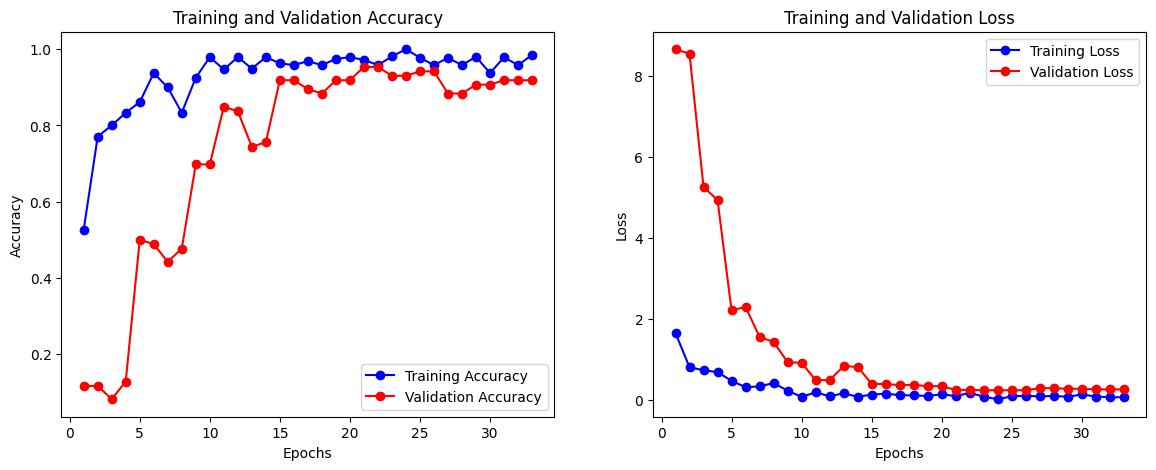

In [14]:
plot_learning_curves(history)